# Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import os
from tqdm import tqdm
from pprint import pprint
from mpl_toolkits.axes_grid1 import ImageGrid
import math
import tensorflow as tf

%matplotlib inline

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, InputLayer
from tensorflow.keras.utils import plot_model
#from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#!pip install livelossplot
from livelossplot  import PlotLossesKerasTF


In [4]:
# from google.colab import drive

# drive.mount('/content/gdrive')

# Getting Data

In [5]:
DATASET_PATH = './Dataset/Clean Dataset/train_new'

In [6]:
# Getting data from different folders in dataset
# with respective category and saving it in Dataframe
#mount drive to get data


DATA_CATEGORY = ['covid', 'normal']


df = pd.DataFrame(columns=['pixels','category', 'height', 'width', 'Format', 'mode'])

for cat in DATA_CATEGORY:
        cat_path = os.path.join(DATASET_PATH, cat)
        for image_file in tqdm(os.listdir(cat_path), desc=cat +' Reading data...'):
            image_path = os.path.join(cat_path, image_file)
            image = Image.open(image_path)
            img_arr = np.asarray(image)
            df.loc[len(df.index)] = [img_arr, cat, image.size[0], image.size[1], image.format, image.mode]

df.info()

normal Reading data...: 100%|███████████████████████████████████████| 3328/3328 [00:48<00:00, 68.23it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5610 entries, 0 to 5609
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pixels    5610 non-null   object
 1   category  5610 non-null   object
 2   height    5610 non-null   object
 3   width     5610 non-null   object
 4   Format    5610 non-null   object
 5   mode      5610 non-null   object
dtypes: object(6)
memory usage: 306.8+ KB


# Data Analysis

In [7]:
df.head()

,pixels,category,height,width,Format,mode
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",covid,512,512,JPEG,RGB
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",covid,512,512,JPEG,RGB
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",covid,512,512,JPEG,RGB
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",covid,512,512,JPEG,RGB
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",covid,512,512,JPEG,RGB


In [ ]:
df.describe()

In [ ]:
sns.countplot(x='category', data=df);

In [ ]:
df['Format'].value_counts()

In [ ]:
df['mode'].value_counts()               

# Preprocessing Data

In [19]:
color_mode = "rgb"
number_colour_layers = 3
image_size = (512, 512)   # Taking image size for about 75% data
batch_size = 32
image_shape = image_size + (number_colour_layers,)
print(image_shape)

(512, 512, 3)


In [20]:
# from tensorflow.keras.preprocessing import image_dataset_from_directory 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# rotation_range=20,
#                     width_shift_range=0.2,
#                     height_shift_range=0.2,
#                     validation_split=0.2

In [21]:
datagen_args = dict(rescale=(1/255.),
                validation_split=0.2
                    )

datagen = ImageDataGenerator(**datagen_args)


train_datagen = datagen.flow_from_directory(DATASET_PATH,
                                            target_size=image_size,
                                            color_mode=color_mode,
                                            batch_size=batch_size,
                                            subset='training'
                                            )

validation_datagen = datagen.flow_from_directory(DATASET_PATH,
                                            target_size=image_size,
                                            color_mode=color_mode,
                                            batch_size=batch_size,
                                            subset='validation')


Found 4489 images belonging to 2 classes.
Found 1121 images belonging to 2 classes.


In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
def get_image_data(data_path, color_mode, image_size, seed = None, subset = None, validation_split = None):
    if subset:
        validation_split = 0.2
    raw_data_set = \
    tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        color_mode=color_mode,
        image_size=image_size,
        seed=seed,
        validation_split=validation_split, 
        subset=subset
    )
    
    raw_data_set.class_names.sort()
    
    return {
        "data": raw_data_set.cache().prefetch(
        buffer_size = tf.data.experimental.AUTOTUNE
        ),
        "classNames": raw_data_set.class_names
    }

In [9]:
training_ds = get_image_data(
    DATASET_PATH,
    color_mode=color_mode,
    image_size=image_size,
    seed=42,
    subset = "training"
)
validation_ds = get_image_data(
   DATASET_PATH,
    color_mode=color_mode,
    image_size=image_size,
    seed=42,
    subset = "validation"
)

Found 5610 files belonging to 2 classes.
Using 4488 files for training.
Found 5610 files belonging to 2 classes.
Using 1122 files for validation.


In [22]:
print('Number of training samples: ', train_datagen.samples)
print('Number of training classes: ', len(train_datagen.class_indices))
pprint("classes : {}".format(train_datagen.class_indices))
pprint("few file names: {}".format(train_datagen.filenames[:5]))

Number of training samples:  4489
Number of training classes:  2
"classes : {'covid': 0, 'normal': 1}"
("few file names: ['covid\\\\137covid_patient18_SR_4_IM00013.jpg', "
 "'covid\\\\137covid_patient18_SR_4_IM00024.jpg', "
 "'covid\\\\137covid_patient18_SR_4_IM00025.jpg', "
 "'covid\\\\137covid_patient18_SR_4_IM00026.jpg', "
 "'covid\\\\137covid_patient18_SR_4_IM00027.jpg']")


In [14]:
sample = next(train_datagen)
x, y = sample
print('Image info :', x.shape)
print('label info : ', y.shape)
y_int = np.argmax(y, axis=1)

class_mapping = {0:'Covid',
                 1:'non-Covid'}

Image info : (64, 512, 512, 3)
label info :  (64, 2)


In [15]:
def show_grid(image_list, nrows, ncols, label_list=None, show_labels=False, savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize, frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(class_mapping[y_int[i]])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

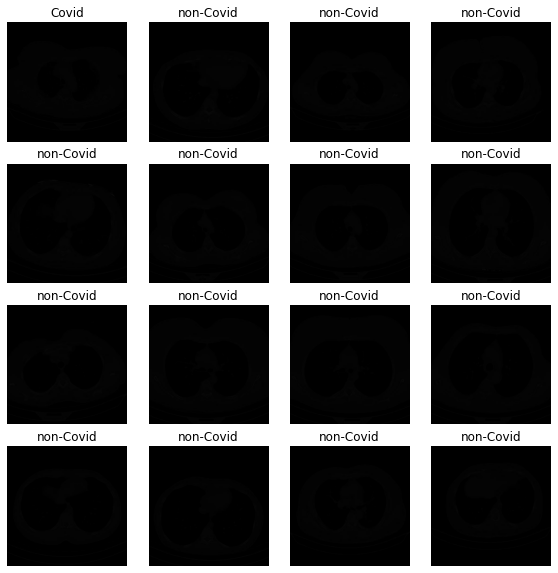

In [16]:
show_grid(x,4,4,label_list=y_int,show_labels=True,figsize=(20,10))


# benchmark model

In [11]:
models = []

In [12]:
def get_benchmark_model(input_shape):
    x = Input(shape=input_shape)
    h = Conv2D(32, padding='same', kernel_size=(3,3), activation='relu')(x)
    h = Conv2D(32, padding='same', kernel_size=(3,3), activation='relu')(h)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Conv2D(64, padding='same', kernel_size=(3,3), activation='relu')(h)
    h = Conv2D(64, padding='same', kernel_size=(3,3), activation='relu')(h)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Conv2D(128, kernel_size=(3,3), activation='relu')(h)
    h = Conv2D(128, kernel_size=(3,3), activation='relu')(h)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Flatten()(h)
    h = Dense(128, activation='relu')(h)
    h = Dropout(.5)(h)
    output = Dense(2, activation='softmax')(h)

    model = tf.keras.Model(inputs=x, outputs=output)
    
    model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
    return model

In [13]:
benchmark_model = get_benchmark_model(image_shape)
benchmark_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0     

In [14]:
def train_model(model, train_gen, valid_gen, epochs, model_name):
  train_steps_per_epoch = train_gen.n // train_gen.batch_size
  val_steps_per_epoch = valid_gen.n // valid_gen.batch_size
  earlyStopping = EarlyStopping(monitor='val_loss',
                                patience=15,
                                mode='min')
  callbacks = [ earlyStopping,  PlotLossesKerasTF()]
  history = model.fit(train_gen,
                      steps_per_epoch = train_steps_per_epoch,
                      epochs = epochs,
                      validation_data = valid_gen,
                      callbacks=callbacks
                      )
  model.save("/content/gdrive/MyDrive/Practice ML/covid ct scan/{}.h5".format(model_name))
  return history

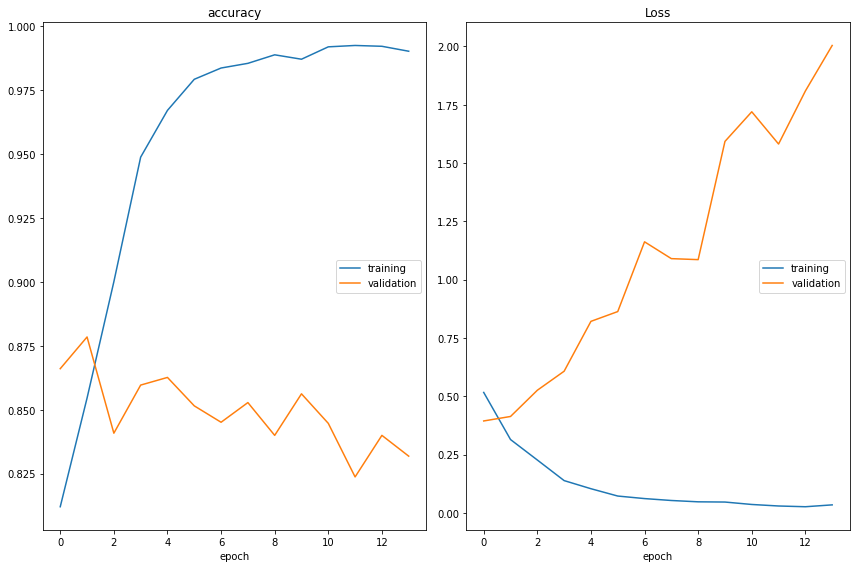

accuracy
	training         	 (min:    0.812, max:    0.993, cur:    0.990)
	validation       	 (min:    0.824, max:    0.878, cur:    0.832)
Loss
	training         	 (min:    0.027, max:    0.517, cur:    0.035)
	validation       	 (min:    0.394, max:    2.004, cur:    2.004)
Epoch 15/100
 72/146 [=============>................] - ETA: 1:18 - loss: 0.0276 - accuracy: 0.9931

In [ ]:
history = train_model(benchmark_model, train_datagen, validation_datagen, 100, 'benchmark_model')
models.append(benchmark_model)

# Transfer Learning

In [ ]:
# # VGG16
# vgg19
# resnet
# efficientNet
# iceptionV3

In [15]:
def develop_model(pre_trained_model, preprocess_input, input_shape):
  temp = pre_trained_model(include_top=False,
                           weights='imagenet', 
                          input_shape=input_shape)
  output = temp.layers[-1].output
  output = Flatten()(output)
  temp_model = Model(temp.input, output)

  temp_model.summary()

  temp_model.trainable = False
  for layer in temp_model.layers:
    layer.trainable = False

  model = Sequential()
  model.add(temp_model)
  model.add(Dense(512, activation='relu', input_dim=input_shape))
  model.add(Dropout(0.3))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(2, activation='sigmoid'))

  model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

  
  return model

## 1.ResNet

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

resnet_model = develop_model(ResNet50, preprocess_input, image_shape)
resnet_model.summary()

# res = ResNet50()
# res.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
history = train_model(resnet_model, train_datagen, validation_datagen, 100, 'resnet_model')
models.append(resnet_model)

## 1. VGG 16

In [17]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg_model= develop_model(VGG16, None, image_shape)
vgg_model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
____________________________________________________________

In [ ]:
history = train_model(vgg_model, train_datagen, validation_datagen, 100, 'vgg16')
models.append(vgg_model)

Epoch 1/100


## Inception V3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception_model = develop_model(InceptionV3, None, image_shape)
inception_model.summary()

In [ ]:
history = train_model(inception_model,train_datagen, validation_datagen, 100)
models.append(inception_model)

## Vgg 19

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

vgg19_model = develop_model(VGG19, None, image_shape)
vgg19_model.summary()

In [ ]:
history = train_model(vgg19_model, train_datagen, validation_datagen, 100)
models.append(vgg19_model)

## DenseNet

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet201

densenet_model = develop_model(DenseNet201, None, image_shape)
densenet_model.summary()

In [ ]:
history = train_model(densenet_model, train_datagen, validation_datagen, 100)
models.append(densenet_model)

## EfficientNet

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB5

efficient_model = develop_model(EfficientNetB5, None, image_shape)
efficient_model.summary()

In [ ]:
history = train_model(efficient_model, train_datagen, validation_datagen, 100)
models.append(efficient_model)